In [25]:
# !pip install matplotlib
!pip install tqdm

In [32]:
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd
import os
from tqdm import tqdm as tqdm 
from IPython.display import Image
from pathlib import Path
import json
import numpy as np

In [33]:
# results_root = "/storage/czw/linear_voltage_single_electrode_SS_SM_prototype/linear_voltage_single_electrode"
results_root = "/storage/czw/btbench/single_electrode_btbench_full/eval_results_full_SS_SM/linear_voltage_single_electrode"


In [34]:
def get_test_results(results, eval_name):
    eval_results = results["evaluation_results"]
    assert len(eval_results.keys()) == 1
    records = []
    for subject_trial in eval_results:
        subject = subject_trial.split("_")[0][len("btbank"):]
        trial = subject_trial.split("_")[1]
        subject_trial_results = eval_results[subject_trial]['electrode']
        for electrode in subject_trial_results:
            electrode_results = subject_trial_results[electrode]
            time_bin_results = electrode_results["time_bins"]
            for time_bin in time_bin_results:
                time_bin_start = time_bin['time_bin_start']
                fold_results = time_bin['folds']
                avg_test = np.mean([f['test_roc_auc'] for f in fold_results])
                records.append({
                    "subject": subject,
                    "trial": trial,
                    "ID": f'{electrode}-sub_{subject}',
                    "electrode": electrode,
                    "avg_test": avg_test,
                    "time_bin": time_bin_start,
                    "task": eval_name
                })
        return records

In [35]:
all_records = []
all_results_paths = glob(os.path.join(results_root, "*"))
for path in tqdm(all_results_paths):
    name = Path(path).stem
    sub_id = name.split("_")[1][len("btbank"):]
    trial_id = name.split("_")[2]
    eval_name = "_".join(name.split("_")[3:])
    with open(path, "r") as f:
        results = json.load(f)
        test_results = get_test_results(results, eval_name)
    all_records += test_results
results_df = pd.DataFrame.from_records(all_records)

100%|██████████████████████████████████████████████████████████████████████████████████| 494/494 [00:27<00:00, 18.05it/s]


In [37]:
#https://bookdown.org/u0243256/tbicc/freesurfer.html
dk2text_d = {'supramarginal': 'supramarginal',
             'postcentral': 'postcentral',
             'medialorbitofrontal': 'medial orbitofrontal',
             'caudalmiddlefrontal': 'caudal middle frontal',
             'posteriorcingulate': 'posterior cingulate',
             'middletemporal': 'middle temporal',
             'superiortemporal': 'superior temporal',
             'bankssts': 'Banks of sup. temp. sul.',
             'superiorparietal': 'superior parietal',
             'precuneus': 'precuneus',
             'entorhinal': 'entorhinal',
             'parstriangularis': 'pars triangularis',
             'precentral': 'precentral',
             'parsorbitalis': 'pars orbitalis',
             'insula': 'insula',
             'parahippocampal': 'parahippocampal',
             'inferiortemporal': 'inferior temporal',
             'parsopercularis': 'pars opercularis',
             'fusiform': 'fusiform',
             'transversetemporal': 'transverse temporal',
             'superiorfrontal': 'superior frontal',
             'paracentral': 'paracentral',
             'lateralorbitofrontal': 'lateral orbitofrontal',
             'caudalanteriorcingulate': 'caudal anterior cingulate',
             'inferiorparietal': 'inferior parietal',
             'rostralanteriorcingulate': 'rostral anterior cingulate',
             'isthmuscingulate': 'isthmus cingulate',
             'temporalpole': 'temporal pole',
             'rostralmiddlefrontal': 'rostral middle frontal',
             'amygdala': 'Amygdala',
             'hippocampus': 'Hippocampus',
             'inf-lat-vent': 'inferior lateral ventrical',
             'putamen': 'putamen',
             'unknown': 'unknown'}

dk_names = ["superior frontal", "rostral middle frontal", "caudal middle frontal", "pars opercularis",
           "pars triangularis", "pars orbitalis", "lateral orbitofrontal", "medial orbitofrontal",
           "precentral", "paracentral", "frontal pole", "superior parietal", "inferior parietal",
           "supramarginal", "postcentral", "precuneus", "superior temporal", "middle temporal",
           "inferior temporal", "bankssts", "fusiform", "transverse temporal",
           "entorhinal","temporal pole", "parahippocampal", "lateral occipital", "lingual", "cuneus",
           "pericalcarine","rostral anterior cingulate", "caudal anterior cingulate",
           "posterior cingulate","isthmus cingulate", "insula"]

region_ids = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6]
name2region_id = {n:x for x,n in zip(region_ids, dk_names)}
region_id2region_name = {x+1:n for x,n in enumerate(["Frontal", "Parietal", "Temporal", "Occipital", "Cingulate", "Insula"])}

def dk2text(label):
    l = label.replace('ctx-','')
    l = l.replace('rh-','')
    l = l.replace('lh-','')
    l = l.replace('Left-','')
    l = l.replace('Right-','')
    l = l.lower()
    return dk2text_d[l]

def dk2region(label):
    dk_name = dk2text(label)
    if dk_name in name2region_id:
        return region_id2region_name[name2region_id[dk_name]]
    return dk_name

In [45]:
all_localization_dfs = []
braintreebank_root = "/storage/czw/braintreebank_data/"
for fpath in glob(os.path.join(braintreebank_root, "localization/sub_*/depth-wm.csv")):
    sub_localization_df = pd.read_csv(fpath)
    sub_localization_df["Subject"] = subject = os.path.dirname(fpath).split("/")[-1]
    all_localization_dfs.append(sub_localization_df)
all_localization_df = pd.concat(all_localization_dfs)

all_localization_df["region_common_name"] = [dk2region(x) for x in all_localization_df.DesikanKilliany]
all_localization_df["common_name"] = [dk2text(x) for x in all_localization_df.DesikanKilliany]
all_localization_df["Hemisphere"] = [0 if '-lh-' in x else 1 for x in all_localization_df.DesikanKilliany]

In [46]:
all_localization_df["ID"] = all_localization_df.Electrode + "-" + all_localization_df.Subject
localization_merged_df = pd.merge(results_df, all_localization_df, on="ID", how="left")

In [55]:
from nilearn.datasets import (
    fetch_atlas_surf_destrieux,
    load_fsaverage,
    load_fsaverage_data,
)
from nilearn.surface import SurfaceImage

fsaverage = load_fsaverage("fsaverage5")
destrieux = fetch_atlas_surf_destrieux()
destrieux_atlas = SurfaceImage(
    mesh=fsaverage["pial"],
    data={
        "left": destrieux["map_left"],
        "right": destrieux["map_right"],
    },
)

# The parcellation is already loaded into memory
left_parcellation = destrieux['map_left']
right_parcellation = destrieux['map_right']


# The labels are stored as bytes for the Destrieux atlas.
# For convenience we decode them to string.
labels = [x.decode("utf-8") for x in destrieux.labels]

# Retrieve fsaverage5 surface dataset for the plotting background.
# It contains the surface template as pial and inflated version.
fsaverage_meshes = load_fsaverage()

# The fsaverage meshes contains the FileMesh objects:
print(f"{fsaverage_meshes['pial'].parts['left']=}")
print(f"{fsaverage_meshes['inflated'].parts['left']=}")

# The fsaverage data contains file names pointing to the file locations
# The sulcal depth maps will be is used for shading.
fsaverage_sulcal = load_fsaverage_data(data_type="sulcal")
print(f"{fsaverage_sulcal=}")

[get_dataset_dir] Dataset found in /afs/csail.mit.edu/u/c/czw/nilearn_data/destrieux_surface
fsaverage_meshes['pial'].parts['left']=<FileMesh with 10242 vertices and 20480 faces.>
fsaverage_meshes['inflated'].parts['left']=<FileMesh with 10242 vertices and 20480 faces.>
fsaverage_sulcal=<SurfaceImage (20484,)>


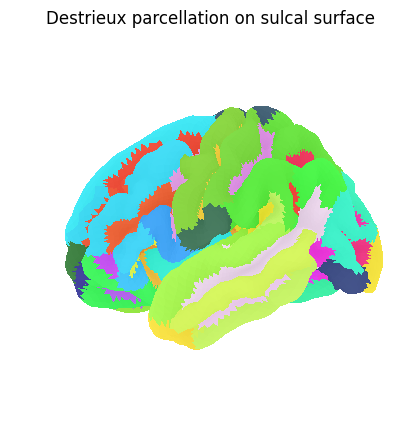

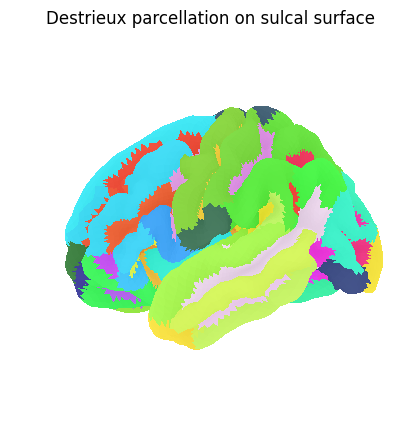

In [5]:
from nilearn.plotting import plot_surf_roi, show

plot_surf_roi(
    roi_map=destrieux_atlas,
    hemi="left",
    view="lateral",
    bg_map=fsaverage_sulcal,
    bg_on_data=True,
    darkness=0.5,
    title="Destrieux parcellation on sulcal surface",
)

In [40]:
# labels

In [ ]:
# !pip uninstall nilearn

In [11]:
!which python

/storage/czw/anaconda3/envs/sss/bin/python


In [12]:
fsaverage_meshes['pial']

In [61]:
def get_parcellation(region_results, parcellation):
    labels = destrieux["labels"]
    results_parcellation = parcellation.copy()
    results_parcellation = np.zeros(parcellation.shape)
    for i, label in enumerate(labels):
        region_value = 0    
        region = label.decode("UTF-8")
        if region in region_results.index:
            region_value = region_results.loc[region]['avg_test']
            results_parcellation[parcellation==i] = region_value
#             results_parcellation[parcellation==i] = 1.0 #TODO
    #         print(results_parcellation[parcellation==i])
#         if region=="G_temp_sup-Lateral":#TODO
#             results_parcellation[parcellation==i] = 0.5 #TODO
#             print("ayy", i)
        # if region=="S_temporal_sup":#TODO
        #     results_parcellation[parcellation==i] = 1 #TODO
        #     print("ayy", i)
    return results_parcellation

In [62]:
# localization_merged_df

In [63]:
# left_task_results

,subject,trial,ID,electrode,avg_test,time_bin,task,Electrode,L,I,P,DesikanKilliany,Destrieux,DKT,ShiftDist,ConfType,Subject,region_common_name,common_name,Hemisphere
0,9,0,T1b1-sub_9,T1b1,0.481273,-0.500,speech,T1b1,174.0,121.0,138.0,ctx-lh-transversetemporal,ctx_lh_G_temp_sup-G_T_transv,ctx-lh-transversetemporal,0.0,1.0,sub_9,Temporal,transverse temporal,0.0
1,9,0,T1b1-sub_9,T1b1,0.477107,-0.375,speech,T1b1,174.0,121.0,138.0,ctx-lh-transversetemporal,ctx_lh_G_temp_sup-G_T_transv,ctx-lh-transversetemporal,0.0,1.0,sub_9,Temporal,transverse temporal,0.0
2,9,0,T1b1-sub_9,T1b1,0.494581,-0.250,speech,T1b1,174.0,121.0,138.0,ctx-lh-transversetemporal,ctx_lh_G_temp_sup-G_T_transv,ctx-lh-transversetemporal,0.0,1.0,sub_9,Temporal,transverse temporal,0.0
3,9,0,T1b1-sub_9,T1b1,0.479030,-0.125,speech,T1b1,174.0,121.0,138.0,ctx-lh-transversetemporal,ctx_lh_G_temp_sup-G_T_transv,ctx-lh-transversetemporal,0.0,1.0,sub_9,Temporal,transverse temporal,0.0
4,9,0,T1b1-sub_9,T1b1,0.481981,0.000,speech,T1b1,174.0,121.0,138.0,ctx-lh-transversetemporal,ctx_lh_G_temp_sup-G_T_transv,ctx-lh-transversetemporal,0.0,1.0,sub_9,Temporal,transverse temporal,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002903,2,4,RT1c10-sub_2,RT1c10,0.531272,0.625,speech,RT1c10,61.0,112.0,142.0,ctx-rh-superiortemporal,ctx_rh_G_temp_sup-Lateral,ctx-rh-superiortemporal,0.0,2.0,sub_2,Temporal,superior temporal,1.0
1002904,2,4,RT1c10-sub_2,RT1c10,0.542907,0.750,speech,RT1c10,61.0,112.0,142.0,ctx-rh-superiortemporal,ctx_rh_G_temp_sup-Lateral,ctx-rh-superiortemporal,0.0,2.0,sub_2,Temporal,superior temporal,1.0
1002905,2,4,RT1c10-sub_2,RT1c10,0.545646,0.875,speech,RT1c10,61.0,112.0,142.0,ctx-rh-superiortemporal,ctx_rh_G_temp_sup-Lateral,ctx-rh-superiortemporal,0.0,2.0,sub_2,Temporal,superior temporal,1.0
1002906,2,4,RT1c10-sub_2,RT1c10,0.543737,1.000,speech,RT1c10,61.0,112.0,142.0,ctx-rh-superiortemporal,ctx_rh_G_temp_sup-Lateral,ctx-rh-superiortemporal,0.0,2.0,sub_2,Temporal,superior temporal,1.0


left max: 0.8608777838191765
right max: 0.6403439826026908


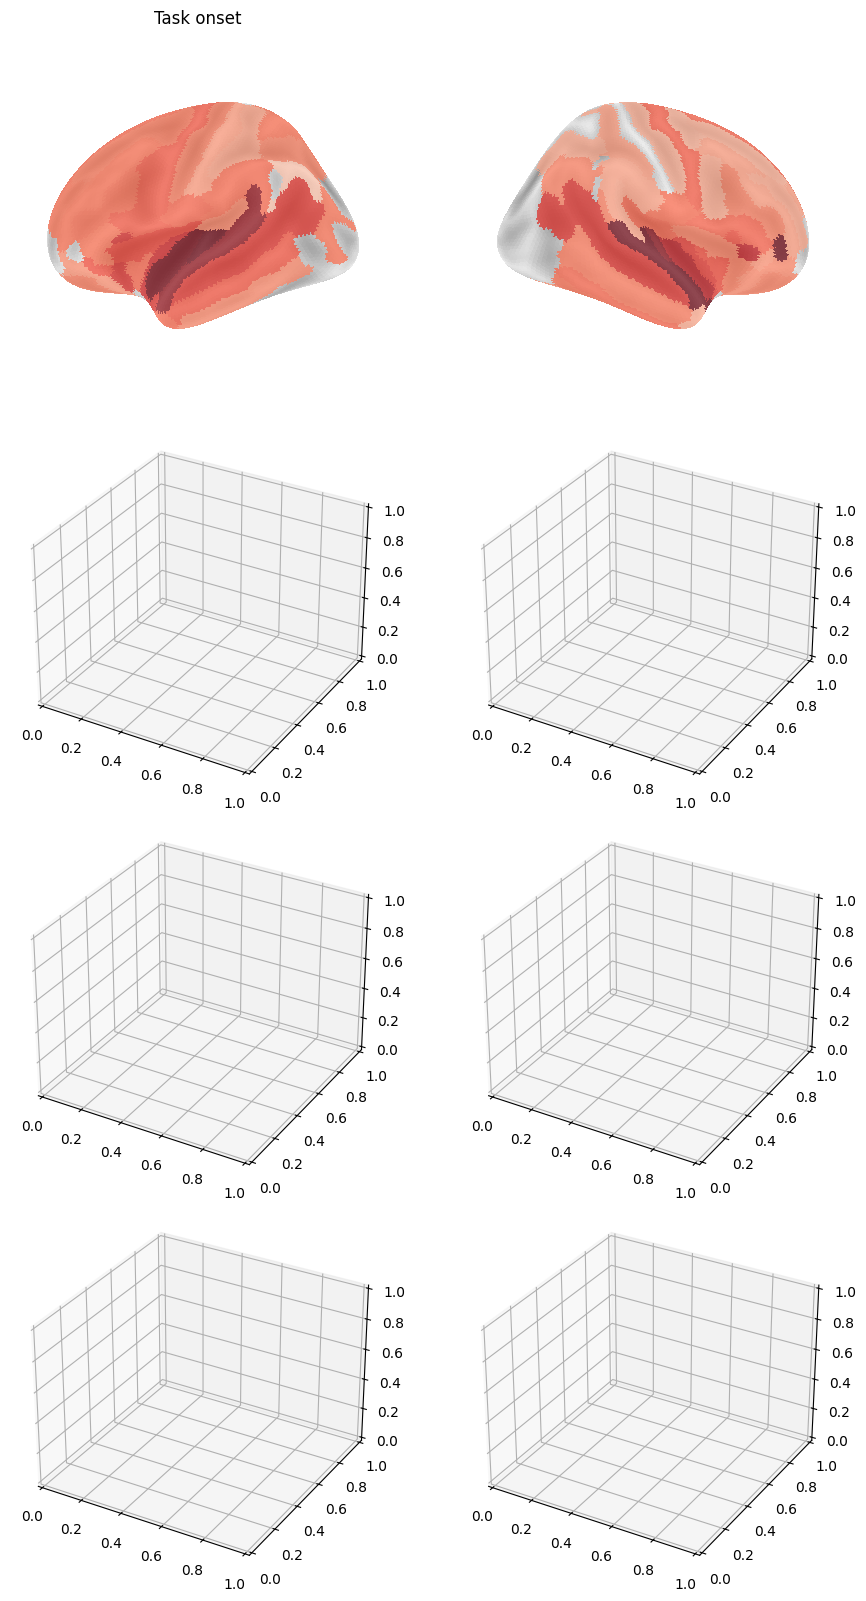

In [102]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,4*4), subplot_kw={'projection': '3d'})

task = "onset"
task_results = localization_merged_df[localization_merged_df.task==task]
# task_results = get_task_results(task)
## Drop the regions that have less than 2 electrodes
left_task_results = task_results[task_results.Hemisphere==0]
right_task_results = task_results[task_results.Hemisphere==1]
left_task_results = left_task_results[left_task_results.groupby("Destrieux").Destrieux.transform('count') > 0]
right_task_results = right_task_results[right_task_results.groupby("Destrieux").Destrieux.transform('count') > 0]
region_results_left = left_task_results[["Hemisphere", "Destrieux", "avg_test"]].groupby("Destrieux").quantile(q=0.90)
region_results_left.index = [x[len("ctx_lh_"):] if "_lh_" in x else x for x in region_results_left.index ]
region_results_right = right_task_results[["Hemisphere", "Destrieux", "avg_test"]].groupby("Destrieux").quantile(q=0.90)
region_results_right.index = [x[len("ctx_lh_"):] if "_rh_" in x else x for x in region_results_right.index ]

# if (task == "word_onset") or (task == "sentence_onset"): 
#     print(task)
#     display(region_results_left.sort_values("value", ascending=False).head(10))
    # region_results_left = region_results_left.reset_index()
    # region_results_left[region_results_left["Destrieux"]== "S_circular_insula_ant"]["value"] = 0.99
left_results_parcellation = get_parcellation(region_results_left, left_parcellation)
right_results_parcellation = get_parcellation(region_results_right, right_parcellation)

print("left max:", left_results_parcellation.max())
print("right max:", right_results_parcellation.max())
max_avg = (left_results_parcellation.max() + right_results_parcellation.max()) / 2
max_all = max(left_results_parcellation.max(), right_results_parcellation.max())

plot_surf_roi(fsaverage['inflated'], roi_map=left_results_parcellation,
                    hemi='left', view='lateral',
                    bg_map=fsaverage_sulcal, bg_on_data=True,
                    darkness=.5, cmap="Reds", vmin=0.48, vmax=0.6,
                    # darkness=.5, cmap="Reds",
                    axes=ax[i][0])

plot_surf_roi(fsaverage['inflated'], roi_map=right_results_parcellation,
                    hemi='right', view='lateral',
                    bg_map=fsaverage_sulcal, bg_on_data=True,
                    darkness=.5, cmap="Reds", vmin=0.48, vmax=0.6,
                    # darkness=.5, cmap="Reds",
                    axes=ax[i][1])
ax[i][0].set_title(f"Task {task}")
fig.tight_layout()
plt.show()


In [101]:
left_results_parcellation

array([0.56000556, 0.54376091, 0.54496312, ..., 0.55343505, 0.55248139,
       0.55248139])

In [81]:
region_results_left.index = [x[len("ctx_lh_"):] for x in region_results_left.index]

Index(['ctx_lh_G_Ins_lg_and_S_cent_ins', 'ctx_lh_G_and_S_cingul-Ant',
       'ctx_lh_G_and_S_cingul-Mid-Ant', 'ctx_lh_G_and_S_cingul-Mid-Post',
       'ctx_lh_G_and_S_subcentral', 'ctx_lh_G_cingul-Post-dorsal',
       'ctx_lh_G_front_inf-Opercular', 'ctx_lh_G_front_inf-Orbital',
       'ctx_lh_G_front_inf-Triangul', 'ctx_lh_G_front_middle',
       'ctx_lh_G_front_sup', 'ctx_lh_G_insular_short',
       'ctx_lh_G_oc-temp_med-Parahip', 'ctx_lh_G_occipital_middle',
       'ctx_lh_G_orbital', 'ctx_lh_G_pariet_inf-Angular',
       'ctx_lh_G_pariet_inf-Supramar', 'ctx_lh_G_parietal_sup',
       'ctx_lh_G_postcentral', 'ctx_lh_G_precentral', 'ctx_lh_G_precuneus',
       'ctx_lh_G_rectus', 'ctx_lh_G_temp_sup-G_T_transv',
       'ctx_lh_G_temp_sup-Lateral', 'ctx_lh_G_temp_sup-Plan_polar',
       'ctx_lh_G_temp_sup-Plan_tempo', 'ctx_lh_G_temporal_inf',
       'ctx_lh_G_temporal_middle', 'ctx_lh_Lat_Fis-ant-Horizont',
       'ctx_lh_Lat_Fis-ant-Vertical', 'ctx_lh_Lat_Fis-post',
       'ctx_lh_Pole

In [93]:
region_results_left

,Hemisphere,avg_test
G_Ins_lg_and_S_cent_ins,0.0,0.522570
G_and_S_cingul-Ant,0.0,0.516615
G_and_S_cingul-Mid-Ant,0.0,0.509584
G_and_S_cingul-Mid-Post,0.0,0.509579
G_and_S_subcentral,0.0,0.517966
G_cingul-Post-dorsal,0.0,0.513263
G_front_inf-Opercular,0.0,0.519199
G_front_inf-Orbital,0.0,0.517295
G_front_inf-Triangul,0.0,0.518309
G_front_middle,0.0,0.514638


In [69]:
fsaverage_sulcal

<SurfaceImage (20484,)>

In [78]:
labels

['Unknown',
 'G_and_S_frontomargin',
 'G_and_S_occipital_inf',
 'G_and_S_paracentral',
 'G_and_S_subcentral',
 'G_and_S_transv_frontopol',
 'G_and_S_cingul-Ant',
 'G_and_S_cingul-Mid-Ant',
 'G_and_S_cingul-Mid-Post',
 'G_cingul-Post-dorsal',
 'G_cingul-Post-ventral',
 'G_cuneus',
 'G_front_inf-Opercular',
 'G_front_inf-Orbital',
 'G_front_inf-Triangul',
 'G_front_middle',
 'G_front_sup',
 'G_Ins_lg_and_S_cent_ins',
 'G_insular_short',
 'G_occipital_middle',
 'G_occipital_sup',
 'G_oc-temp_lat-fusifor',
 'G_oc-temp_med-Lingual',
 'G_oc-temp_med-Parahip',
 'G_orbital',
 'G_pariet_inf-Angular',
 'G_pariet_inf-Supramar',
 'G_parietal_sup',
 'G_postcentral',
 'G_precentral',
 'G_precuneus',
 'G_rectus',
 'G_subcallosal',
 'G_temp_sup-G_T_transv',
 'G_temp_sup-Lateral',
 'G_temp_sup-Plan_polar',
 'G_temp_sup-Plan_tempo',
 'G_temporal_inf',
 'G_temporal_middle',
 'Lat_Fis-ant-Horizont',
 'Lat_Fis-ant-Vertical',
 'Lat_Fis-post',
 'Medial_wall',
 'Pole_occipital',
 'Pole_temporal',
 'S_calcarin

In [83]:
region_results_right

,Hemisphere,avg_test
ygdala,1.0,0.512874
ppocampus,1.0,0.511633
f-Lat-Vent,1.0,0.510527
tamen,1.0,0.511163
mygdala,1.0,0.513139
...,...,...
S_suborbital,1.0,0.509708
S_subparietal,1.0,0.508392
S_temporal_inf,1.0,0.511831
S_temporal_sup,1.0,0.514143


In [99]:
left_task_results[["Hemisphere", "Destrieux", "avg_test"]].groupby("Destrieux")

In [104]:
task_order =  ['onset', 'speech', 'volume', 'pitch', 'speaker', 'delta_volume', 'delta_pitch', 'gpt2_surprisal', 'word_length', 'word_gap', 'word_index', 'word_head_pos', 'word_part_speech', 'frame_brightness', 'global_flow', 'local_flow', 'global_flow_angle', 'local_flow_angle', 'face_num']

In [115]:

def plot_task(task, axs):
    task = "onset"
    task_results = localization_merged_df[localization_merged_df.task==task]
    # task_results = get_task_results(task)
    ## Drop the regions that have less than 2 electrodes
    left_task_results = task_results[task_results.Hemisphere==0]
    right_task_results = task_results[task_results.Hemisphere==1]
    left_task_results = left_task_results[left_task_results.groupby("Destrieux").Destrieux.transform('count') > 0]
    right_task_results = right_task_results[right_task_results.groupby("Destrieux").Destrieux.transform('count') > 0]
    region_results_left = left_task_results[["Hemisphere", "Destrieux", "avg_test"]].groupby("Destrieux").quantile(q=0.90)
    region_results_left.index = [x[len("ctx_lh_"):] if "_lh_" in x else x for x in region_results_left.index ]
    region_results_right = right_task_results[["Hemisphere", "Destrieux", "avg_test"]].groupby("Destrieux").quantile(q=0.90)
    region_results_right.index = [x[len("ctx_lh_"):] if "_rh_" in x else x for x in region_results_right.index ]
    
    # if (task == "word_onset") or (task == "sentence_onset"): 
    #     print(task)
    #     display(region_results_left.sort_values("value", ascending=False).head(10))
        # region_results_left = region_results_left.reset_index()
        # region_results_left[region_results_left["Destrieux"]== "S_circular_insula_ant"]["value"] = 0.99
    left_results_parcellation = get_parcellation(region_results_left, left_parcellation)
    right_results_parcellation = get_parcellation(region_results_right, right_parcellation)
    
    print("left max:", left_results_parcellation.max())
    print("right max:", right_results_parcellation.max())
    max_avg = (left_results_parcellation.max() + right_results_parcellation.max()) / 2
    max_all = max(left_results_parcellation.max(), right_results_parcellation.max())
    
    plot_surf_roi(fsaverage['inflated'], roi_map=left_results_parcellation,
                        hemi='left', view='lateral',
                        bg_map=fsaverage_sulcal, bg_on_data=True,
                        darkness=.5, cmap="Reds", vmin=0.48, vmax=0.6,
                        # darkness=.5, cmap="Reds",
                        axes=axs[0])
    
    plot_surf_roi(fsaverage['inflated'], roi_map=right_results_parcellation,
                        hemi='right', view='lateral',
                        bg_map=fsaverage_sulcal, bg_on_data=True,
                        darkness=.5, cmap="Reds", vmin=0.48, vmax=0.6,
                        # darkness=.5, cmap="Reds",
                        axes=axs[1])
    ax[i].set_title(f"Task {task}")
    fig.tight_layout()
    plt.show()


left max: 0.8608777838191765
right max: 0.6403439826026908


AttributeError: 'Axes' object has no attribute 'view_init'

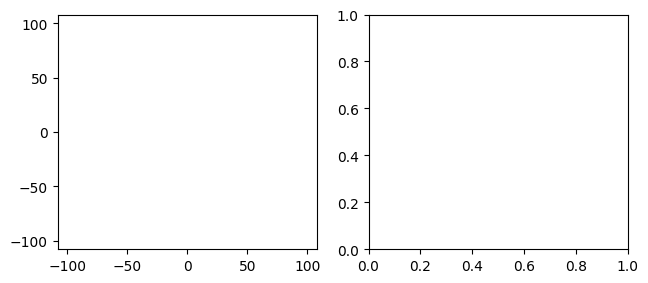

In [119]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(25, 25))

num_cols = 3
num_rows = 7
outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.2, hspace=0.2)

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(num_cols):
        # Index in outer grid
        outer_idx = i * num_cols + j

        if i*num_cols+j >= 19:
            continue
            
        # Define inner 2x1 grid within this cell
        inner = gridspec.GridSpecFromSubplotSpec(
            1, 2, subplot_spec=outer[outer_idx], hspace=0.1
        )
            
        task = task_order[i*num_cols+j]
        ax1 = fig.add_subplot(inner[0])
        ax2 = fig.add_subplot(inner[1])
        ax1.scatterplot9
        # plot_task(task, [ax1, ax2])
                
plt.tight_layout()

In [120]:
ax1

<Axes: >